# Description

In this notebook, we compare the outcomes of different approaches to annotation of spectra of lipids in the context of MS imaging:  
  - Matching theoretical spectra to the average spectrum using `masserstein` 
  - Deconvolving each pixel independently with `masserstein`  
  
We use a custom set of lipid formulas downloaded from LIPID MAPS data base. The set of lipids is supplied with the notebook.  

# Data & modules

In [1]:
%matplotlib notebook

In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
from path import Path
from time import time
import numpy as np

Set the path to your folder with profile-mode MSI data sets here:

In [4]:
# USER INPUT
DATA_FOLDER = Path('Data') 

Set the path to your folder with preprocessed (centroided) MSI data sets here:

In [5]:
# USER INPUT
PREPROCESSED_DATA_FOLDER = Path('Preprocessed data')

Set the path to the output folder to save the annotations:

In [6]:
# USER INPUT
OUTPUT_FOLDER = Path('Annotations')

Select a range of m/z values of interest.    
This should be the same as in Notebook 1.  

In [3]:
# USER INPUT
analyzed_mass_range = (700, 900)

# Library of reference spectra

### Loading molecular formulas

**Note:** This notebook provides an example way of obtaining a library of reference molecular formulas of glycerophospholipids and sphingolipids.   
However, you may use any library you need. Simply create a Python list with formulas of molecules of interest.  

Alternatively, you may directly use a library of reference spectra. In this case, skip this step and proceed to the next step called "Generate the reference spectra".  

Load the molecular formulas of lipids analyzed in the spatialstein paper:

In [7]:
from spatialstein.lipidmaps import load_lipidmaps_formulas

In [8]:
library_path = DATA_FOLDER / 'selected_lipids_28032022.tsv'

In [9]:
reference_molecular_formulas, *_ = load_lipidmaps_formulas(library_path)

Loaded 3523 unique lipid formulas
Loaded 2 unique lipid classes
Loaded 30 unique lipid subclasses
Loaded 14454 unique lipid IDs


In [10]:
print('Example formulas:')
print(reference_molecular_formulas[:5])

Example formulas:
['C90H161NO43', 'C40H77NO9', 'C39H73NO8', 'C30H59O12P', 'C95H168N4O41']


In [11]:
## OPTIONAL USER INPUT
# reference_molecular_formulas = []

### Generating the reference spectra.  

**Note:** This notebook provides an example way of generating reference spectra from a list of molecular formulas. We will assume a potassium adduct. We'll take the peaks that are at least 5% as high as the highest one. However, you may use a custom list of adducts or adjust other parameters. You may also provide a list of reference spectra in other ways, including experimentally measured spectra (common e.g. for NMR spectroscopy, possible but not yet validated for Tandem MS). For this, check the `masserstein` tutorial. For NMR spectra, check the `magnetstein` tutorial. 

In [12]:
from masserstein import Spectrum

In [13]:
# OPTIONAL USER INPUT
adduct_list = ['K']
intensity_threshold = 0.05

In [14]:
reference_spectra = []
for f in reference_molecular_formulas:
    for a in adduct_list:
        S = Spectrum(formula=f, adduct=a, threshold=intensity_threshold)
        S.normalize() 
        reference_spectra.append(S)

We'll discard the spectra that are outside of our mass range of interest. 

In [15]:
is_mass_within_range = [analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1] for s in reference_spectra]
reference_spectra = [s for t, s in zip(is_mass_within_range, reference_spectra) if t]
reference_molecular_formulas = [s for t, s in zip(is_mass_within_range, reference_molecular_formulas) if t]
assert all(s.formula == f for s,f in zip(reference_spectra, reference_molecular_formulas))

print('Retained %i lipid spectra' % len(reference_spectra))

Retained 1206 lipid spectra


Visualize an example theoretical spectrum to ensure it was created correctly:

<IPython.core.display.Javascript object>


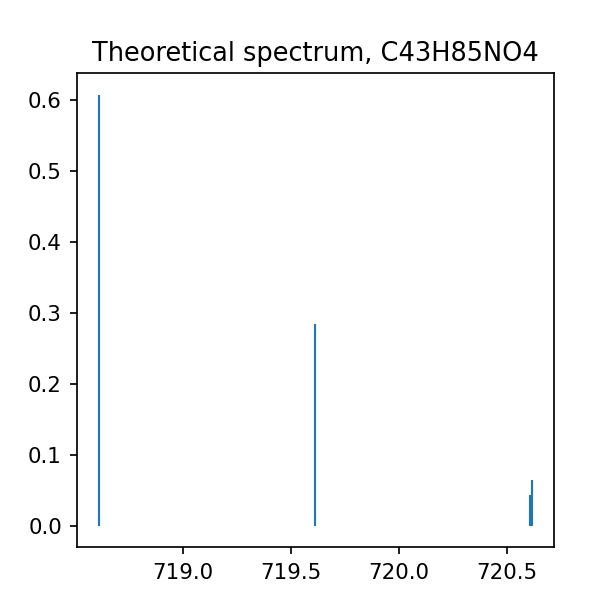

In [16]:
plt.figure(figsize=(4,4))
i = 1000
plt.title('Theoretical spectrum, %s' % reference_spectra[i].formula)
reference_spectra[i].plot()
plt.show()

In [17]:
## OPTIONAL USER INPUT
# reference_spectra = []

# Mass matching accuracy settings

MTD (Maximum Transport Distance; referred to as $\kappa_{mixture}$ in the paper) is the penalty for not matching experimental signal to a theoretical one.   
MTD_th (Maximum Transport Distance from Theoretical Spectra, referred to as $\kappa_{components}$ in the paper) is the penalty for inferring missing experimental signal (e.g. signals below the limit of detection).   

In [18]:
proportion_threshold = 1e-10
MTD = 0.005
MTD_th = 0.015

**Note:** MTD_th needs to be higher than MTD, otherwise the results may be unreliable.  
In extreme cases, when MTD_th is too small (e.g. MTD_th=0.005 for mouse bladder and cerebellum), you may obtain theoretical spectra without corresponding experimental signal. This is because such values allow `masserstein` to assume that most signal may be below the limit of detection.   
Another reason to set MTD_th > MTD is that it's easier to get too much signal in an experimental spectrum (due to noise) than to miss some signal (due to LOD).  

# Fast strategy: annotation of the average spectrum.  
Referred to as the "average, then annotate" strategy.  

In [19]:
from masserstein import estimate_proportions

Load the average spectra calculated in Notebook 1 (or supply your own):

In [20]:
# USER INPUT
msi_names = ['mouse bladder', 'mouse cerebellum']

In [21]:
# OPTIONAL USER INPUT
average_spectrum_filenames = [name + ' centroided average spectrum.tsv' for name in msi_names]

In [22]:
average_spectra = {}
average_spectrum_masses = {}
for name, filename in zip(msi_names, average_spectrum_filenames):
    sp = open(PREPROCESSED_DATA_FOLDER / filename)
    next(sp) # skipping the header - may need changing if custom spectra are used
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra[name] = sp
    average_spectrum_masses[name] = [x[0] for x in sp.confs]

Annotate the average spectra by deconvolving them with `masserstein`.   
Since the code for this task is a one-line application of `masserstein`, the function to annotate an average spectrum is not implemented in the `spatialstein` Python package, but implemented directly in the notebook instead.  
The code below additionally keeps track of the time of the calculations.   

In [23]:
proportions_in_average = {}
regression_times = {}
for name in msi_names:
    av_sp = average_spectra[name]
    s = time()
    regression = estimate_proportions(av_sp, 
                                      reference_spectra, 
                                      MTD=MTD, 
                                      MTD_th=MTD_th)
    e = time()
    proportions_in_average[name] = np.array(regression['proportions'])
    regression_times[name] = e-s
print('Regression times (seconds):')
print(regression_times)

Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:00<00:00, 3929261.09it/s]
Splitting the experimental spectrum into chunks: 423it [00:00, 3279465.05it/s]
Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 4722997.78it/s]
Splitting the experimental spectrum into chunks: 3207it [00:00, 3941146.48it/s]
Deconvolving chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]

Regression times (seconds):
{'mouse bladder': 1.006817102432251, 'mouse cerebellum': 4.902384281158447}


The annotation is now finished.   
We will plot histograms of estimated proportions of reference ions in the average spectrum to detect outliers.  

### Control and validation of the Fast Annotation results

<IPython.core.display.Javascript object>


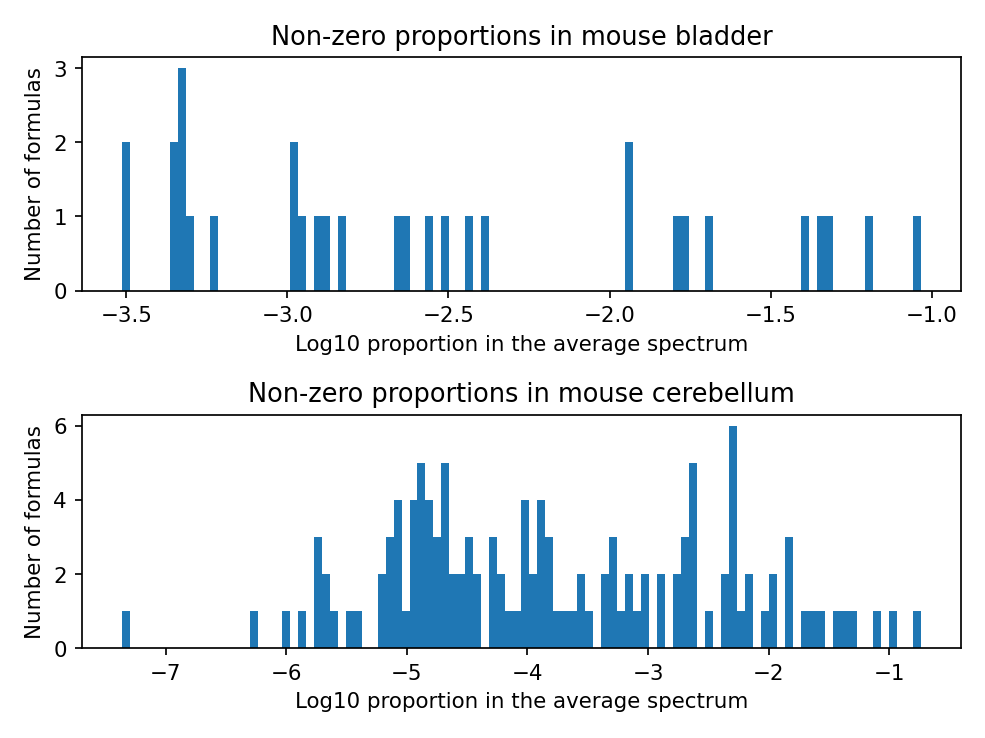

Number of non-zero proportions in mouse bladder 31
Number of non-zero proportions in mouse cerebellum 128


In [24]:
plt.figure()
for i,name in enumerate(msi_names):
    plt.subplot(211+i) 
    pvect = proportions_in_average[name]
    plt.hist(np.log10(pvect[pvect>0]), bins=100)
    plt.title('Non-zero proportions in ' + name)
    plt.xlabel('Log10 proportion in the average spectrum')
    plt.ylabel('Number of formulas')
    print('Number of non-zero proportions in', name, sum(pvect>0))
plt.tight_layout() 

We will also create a plot that shows how many ions have proportions over different thresholds.   
This can be used to remove trace analytes that may be difficult to quantify on some spectrometers.  

<IPython.core.display.Javascript object>


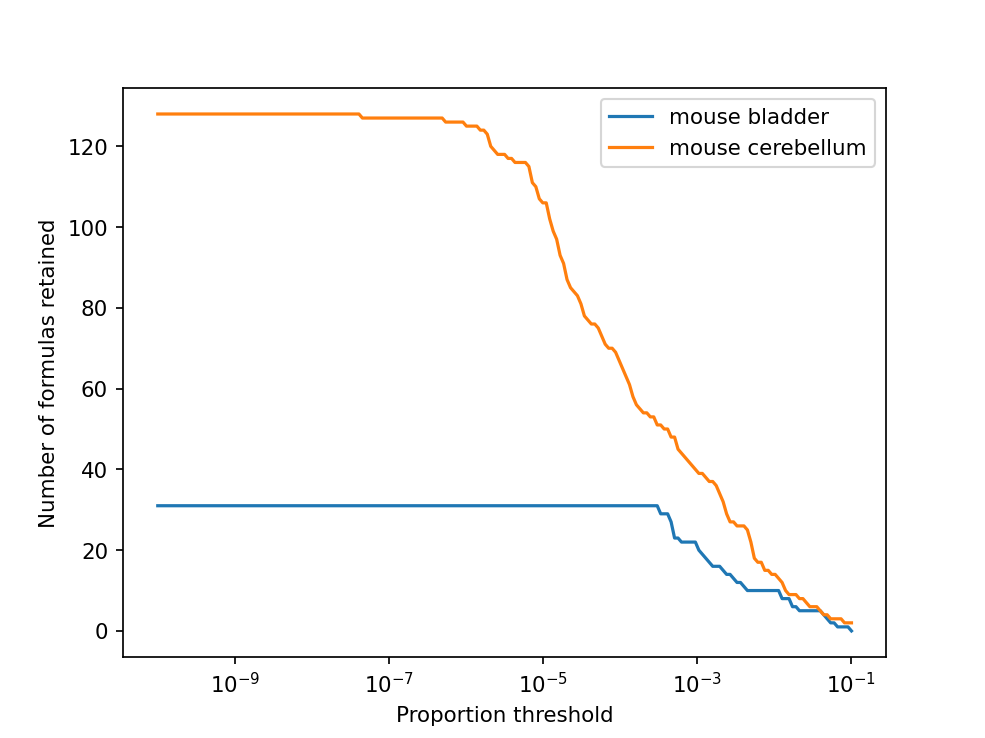

Text(0, 0.5, 'Number of formulas retained')

In [25]:
proportion_thresholds = 10**np.linspace(-10, -1, num=201)
# remaining_ions = {n: [sum(proportions_in_average[name]>thr) for thr in proportion_thresholds] for n in msi_names}

plt.figure()
for name in msi_names:
    ions_over_thresholds = [sum(proportions_in_average[name]>thr) for thr in proportion_thresholds]
    plt.plot(proportion_thresholds, ions_over_thresholds)
plt.gca().set_xscale('log')
plt.legend(msi_names)
plt.xlabel('Proportion threshold')
plt.ylabel('Number of formulas retained')

Select the lower threshold of estimated proportion for an ion to be considered present in the spectrum.   
Ions below the threshold are assumed to be either trace or noise.    
Note that depending on the settings of `masserstein`, and the cleanness of your data set, you may get a certain number of false annotations of the noise.   

In [26]:
proportion_threshold_strategy1 = 0.0  # the proportions needs to be above this threshold

In [27]:
is_annotated_strategy1 = {}
for name in msi_names:
    to_keep = proportions_in_average[name] > proportion_threshold_strategy1
    is_annotated_strategy1[name] = to_keep
    print('Retained %i spectra for %s' % (sum(to_keep), name))

Retained 31 spectra for mouse bladder
Retained 128 spectra for mouse cerebellum


Visualize the filtered annotations by plotting them on the average spectra.    
Each fitted reference spectrum is plotted with a distinct color, and their monoisotopic peaks are indicated with red stars.   

<IPython.core.display.Javascript object>


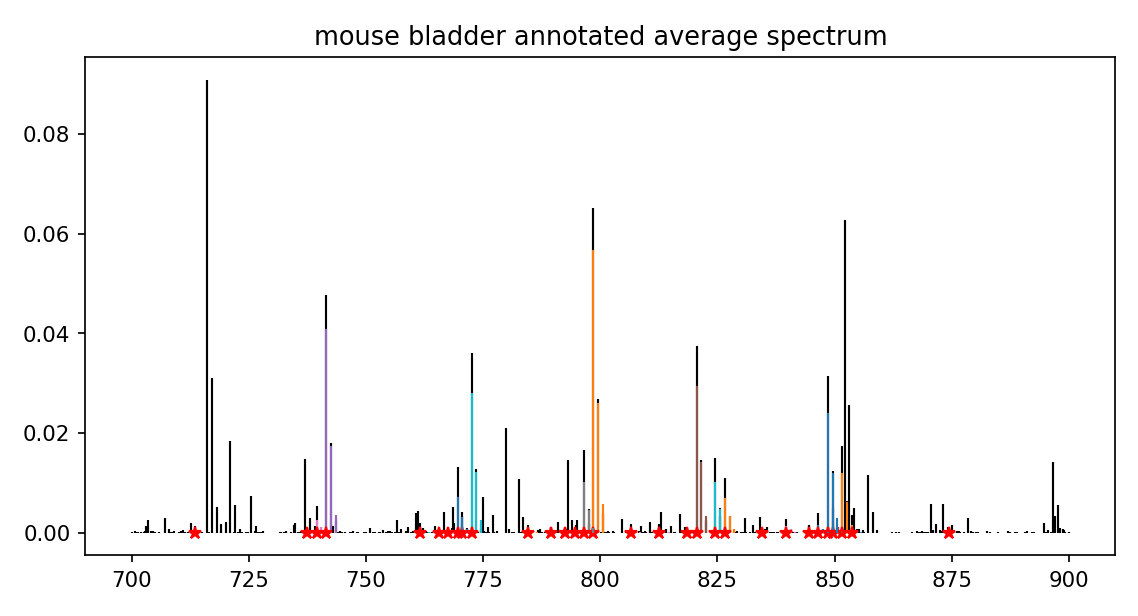

<IPython.core.display.Javascript object>


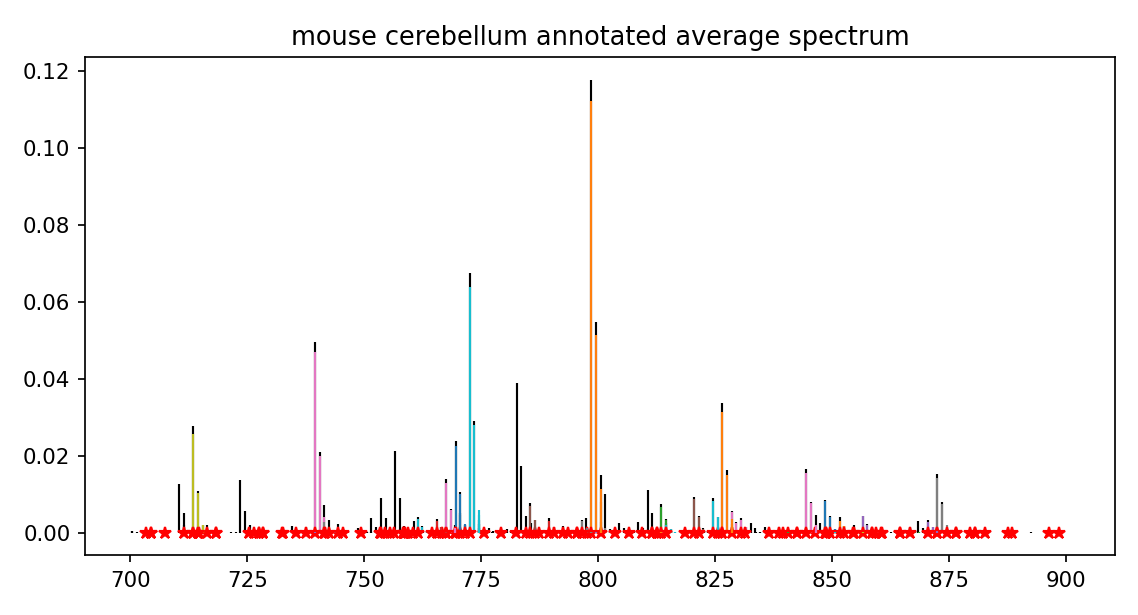

In [28]:
for name in msi_names:
    props = proportions_in_average[name]
    det = is_annotated_strategy1[name]
    
    plt.figure(figsize=(7.4,4))
    plt.title(name + ' annotated average spectrum')
    average_spectra[name].plot(profile=False, color='k', show=False)
    
    for l_id, s, p, d in zip(range(len(reference_spectra)), reference_spectra, props, det):
        if d:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    # plt.savefig('Figs/peak_assignment/' + n + '_average_then_annotate_spectrum.png', dpi=300)
    plt.show()

Save the annotation in a table.   
The table will contain the following columns:  

  - 'Formula', the molecular formula of the ion (without the adduct)  
  - 'Mass', the monoisotopic mass of the ion (including the adduct)   
  - 'Initial proportion', the estimated proportion in the average spectrum  
  - 'Assigned', whether the ion was detected in the average spectrum above the proportion threshold

Note that the table contains all the formulas from the reference library, and indicates which were found in the spectrum.   


In [29]:
for name in msi_names:
    output_file = OUTPUT_FOLDER / name + ' fast annotation results.tsv'
    with open(output_file, 'w') as h:
        props = proportions_in_average[name]
        det = is_annotated_strategy1[name]
        
        # Write the header
        h.write('\t'.join(['Formula', 'Mass', 'Initial proportion', 'Assigned']) + '\n')
        
        # Write the annotated formulas with their initially estimated proportions
        for l_id, s, p, d in zip(range(len(reference_spectra)), reference_spectra, props, det):
            mz = round(s.confs[0][0], 4)
            p = round(p, 4)
            h.write('\t'.join([s.formula, str(mz), str(p), str(d)]) + '\n')

# Thorough strategy: whole-image Masserstein deconvolution  
Referred to as the "annotate, then average" strategy, or annotation pooling

In [30]:
from spatialstein.data_annotation import annotate_msi, annotate_msi_parallel

In [31]:
from pyimzml.ImzMLParser import ImzMLParser
from spatialstein.data_preprocessing import shift_coordinates, get_msi_shape

Load the centroided data sets calculated in Notebook 2 (or supply your own): 

In [32]:
# USER INPUT
msi_filenames = ['mouse bladder centroided.imzML' , 'mouse cerebellum centroided.imzML', '20220419_MouseBrain_female_217E_433x309_Att30_25um.imzml']
msi_names = ['mouse bladder', 'mouse cerebellum', 'mouse brain']

In [33]:
msi_datasets = {}
dataset_shapes = {}
for name, filename in zip(msi_names, msi_filenames):
    dset = ImzMLParser(PREPROCESSED_DATA_FOLDER / filename)
    shift_coordinates(dset)   
    shape = get_msi_shape(dset)
    msi_datasets[name] = dset
    dataset_shapes[name] = shape
    print('Loaded data set', filename)
    print('Shape:', shape)
    print('Number of pixels:', shape[0]*shape[1])

Loaded data set mouse bladder centroided.imzML
Shape: (134, 260)
Number of pixels: 34840
Loaded data set mouse cerebellum centroided.imzML
Shape: (21, 81)
Number of pixels: 1701


/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000080 found with incorrect name "universally unique identifier". Updating name to "magnetic sector".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000511 found with incorrect name "ms levelr". Updating name to "ms level".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000799 found with incorrect name "Custom RAW2IMZML conversi

Loaded data set 20220419_MouseBrain_female_217E_433x309_Att30_25um.imzml
Shape: (309, 433)
Number of pixels: 133797


The control lipids below are based on a manual annotation of the average spectrum; these are common lipids that should be present in typical images. It is important that they do not have any inferences due to overlapping isotopic envelopes, so that their single ion images are expected to be nearly identical before and after deconvolution.  

In [34]:
# OPTIONAL USER INPUT 
control_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
control_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
control_spectrum_ids = [reference_molecular_formulas.index(f) for f in control_formulas]

We use TIC-normalized, centroided images for annotation.  
The code below may run for a long time (20 min for the cerebellum, 2h for the bladder).  

In [35]:
# USER INPUT
max_pixels = 40000

In [36]:
proportions_in_msi = {}
number_of_nonzero_pixels = {}
control_deconvolved_images = {}
for name in msi_names:
    print('Processing image:', name)        
    msi = msi_datasets[name]
    s = time()
    p, n, c = annotate_msi_parallel(
        msi, 
        reference_spectra, 
        MTD,
        MTD_th, 
        control_spectrum_ids,
        max_pixels=max_pixels,
        max_processes = -1  # default = use all cores 
    )
    e = time()
    proportions_in_msi[name] = p
    number_of_nonzero_pixels[name] = n
    control_deconvolved_images[name] = c
    print('Annotation time:', e-s, 'seconds')

Processing image: mouse bladder
Annotation time: 613.7028107643127 seconds
Processing image: mouse cerebellum
Annotation time: 92.91347861289978 seconds
Processing image: mouse brain
Annotation time: 6197.969216346741 seconds


### Control and validation of the Thorough Annotation results

Get the single ion images for the control lipids:

In [37]:
from spatialstein.data_exploration import centroided_ion_image

In [38]:
control_peak_images = {}
for name in msi_names:
    images = np.zeros(dataset_shapes[name] + (len(control_spectrum_ids), ))
    for i, s_id in enumerate(control_spectrum_ids):
        s = reference_spectra[s_id]
        mz = s.confs[0][0]
        img = centroided_ion_image(msi_datasets[name], mz)
        images[...,i] = img
    control_peak_images[name] = images

Display the regression results for the control lipids, compare with their single peak images:

In [39]:
# USER INPUT
control_msi_name = 'mouse bladder'

<IPython.core.display.Javascript object>


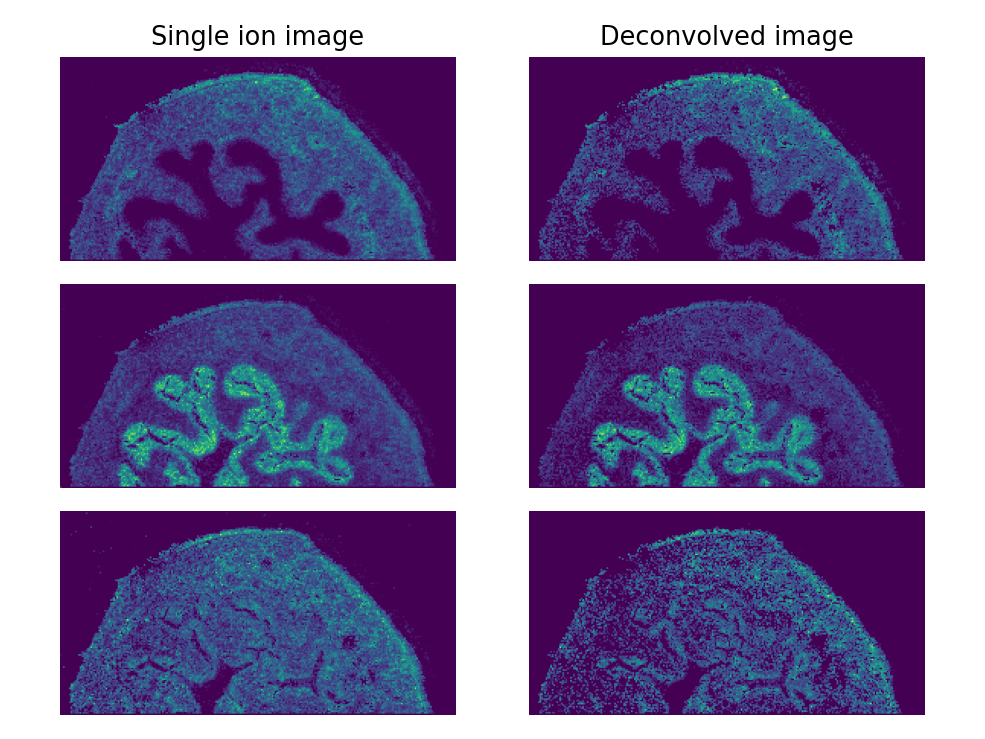

In [40]:
plt.figure()
plt.subplot(len(control_names), 2, 1)
plt.title('Single ion image')
plt.subplot(len(control_names), 2, 2)
plt.title('Deconvolved image')
for i, n in enumerate(control_names):
    plt.subplot(len(control_names), 2, 1+2*i)
    plt.imshow(control_peak_images[control_msi_name][..., i])
    plt.axis('off')
    plt.subplot(len(control_names), 2, 2+2*i)
    plt.imshow(control_deconvolved_images[control_msi_name][..., i])
    plt.axis('off')
plt.tight_layout()
# To save the figure:
# plt.savefig('Figs/peak_assignment/cerebellum_example_images.png', dpi=300)

The deconvolved ion images on the right need to be qualitatively similar to the standard single ion images on the left. The only source of differences between the image should be due to a strict selection of signals by masserstein in order to get an annotation with a high m/z accuracy, and optionally due to a selection of pixels for annotation. Only the selected pixels are analyzed.     

The masserstein parameters for annotation are selected in a way that allows the algorithm to discard signals if they doesn't match the corresponding theoretical m/z very well. This may cause a decrease in signal intensity of lipids in many pixels, which may change the quantitative properties of the spatial distribution, but the qualitative distribution should remain the same. Note that the correct quantitative distribution will be obtained in Notebook 3 with a different set of masserstein parameters.  

Inspect the distribution of the average proportions. Only the non-zero proportions will be shown. 

<IPython.core.display.Javascript object>


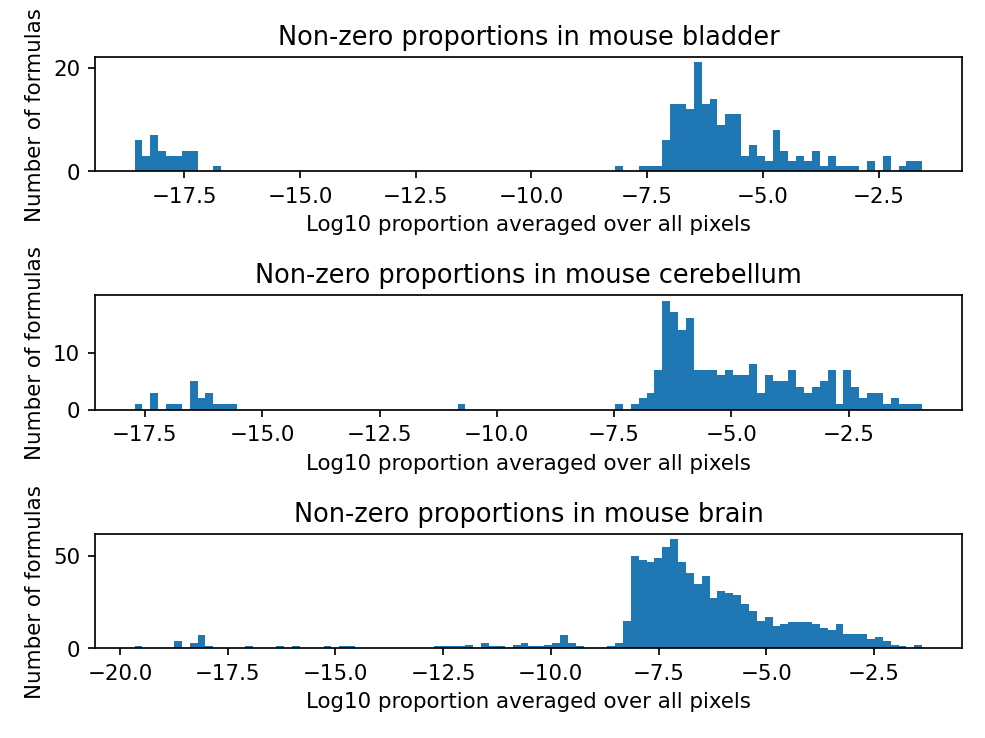

Number of non-zero proportions in mouse bladder 215
Number of non-zero proportions in mouse cerebellum 229
Number of non-zero proportions in mouse brain 896


In [41]:
plt.figure()
for i,n in enumerate(msi_names):
    plt.subplot(len(msi_names), 1, 1+i) 
    pvect = proportions_in_msi[n]
    plt.hist(np.log10(pvect[pvect>0]), bins=100)
    plt.title('Non-zero proportions in ' + n)
    plt.xlabel('Log10 proportion averaged over all pixels')
    plt.ylabel('Number of formulas')
    print('Number of non-zero proportions in', n, sum(pvect>0))
plt.tight_layout() 

Typically, these distributions are markedly different than the ones obtained from the average spectra.  
They main contain two "populations" of ions. The higher "population" typically has a relatively similar range for both the fast and the thorough strategies (from $10^{-8}$ to $10^{-1}$), but additionally there are many more ions with low proportions (below $10^{-12}$) that form a separate "population". These ions are typically restricted to very few pixels, so they appear only when sufficiently many pixels were selected for annotation.   

Inspect the number of pixels for which an ion was detected:

<IPython.core.display.Javascript object>


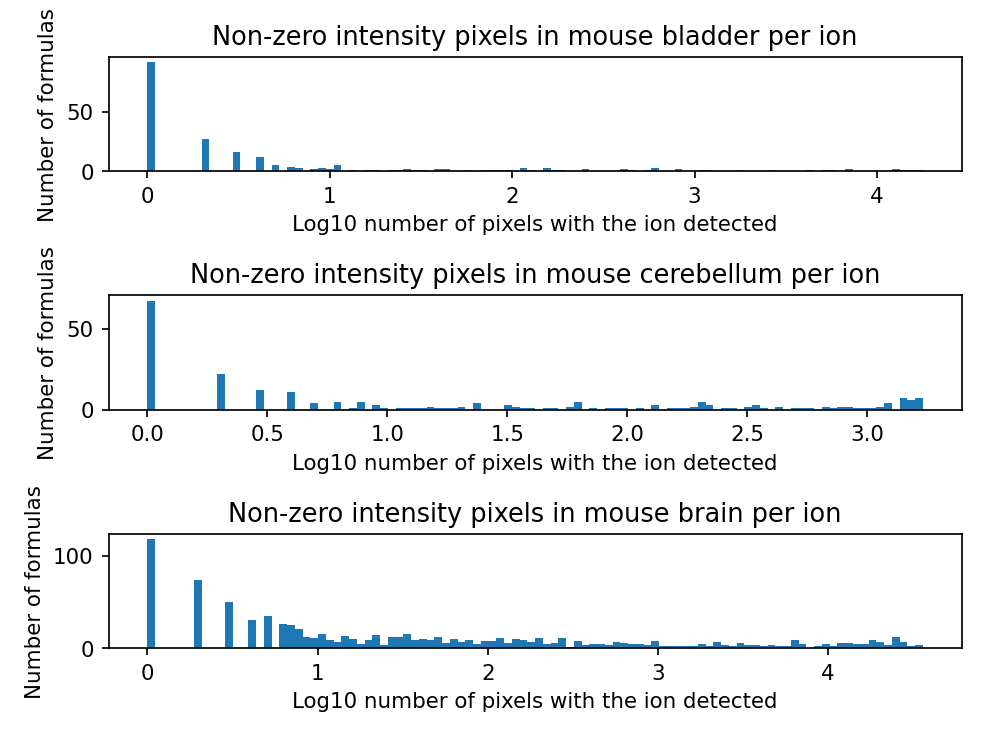

Number of lipids with at least one pixel with a non-zero proportion in mouse bladder 222
Number of lipids with at least one pixel with a non-zero proportion in mouse cerebellum 232
Number of lipids with at least one pixel with a non-zero proportion in mouse brain 914


In [42]:
plt.figure()
for i,n in enumerate(msi_names):
    plt.subplot(len(msi_names), 1, 1+i) 
    nvect = number_of_nonzero_pixels[n]
    plt.hist(np.log10(nvect[nvect>0]), bins=100)
    plt.title('Non-zero intensity pixels in ' + n + ' per ion')
    plt.xlabel('Log10 number of pixels with the ion detected')
    plt.ylabel('Number of formulas')
    print('Number of lipids with at least one pixel with a non-zero proportion in', n, sum(nvect>0))
plt.tight_layout() 

Check the correlation between the average proportions in the whole image (interpreted as the contribution to the total signal) and the number of pixels with a non-zero proportion (interpreted as the spatial prevalence of the lipid):

<IPython.core.display.Javascript object>


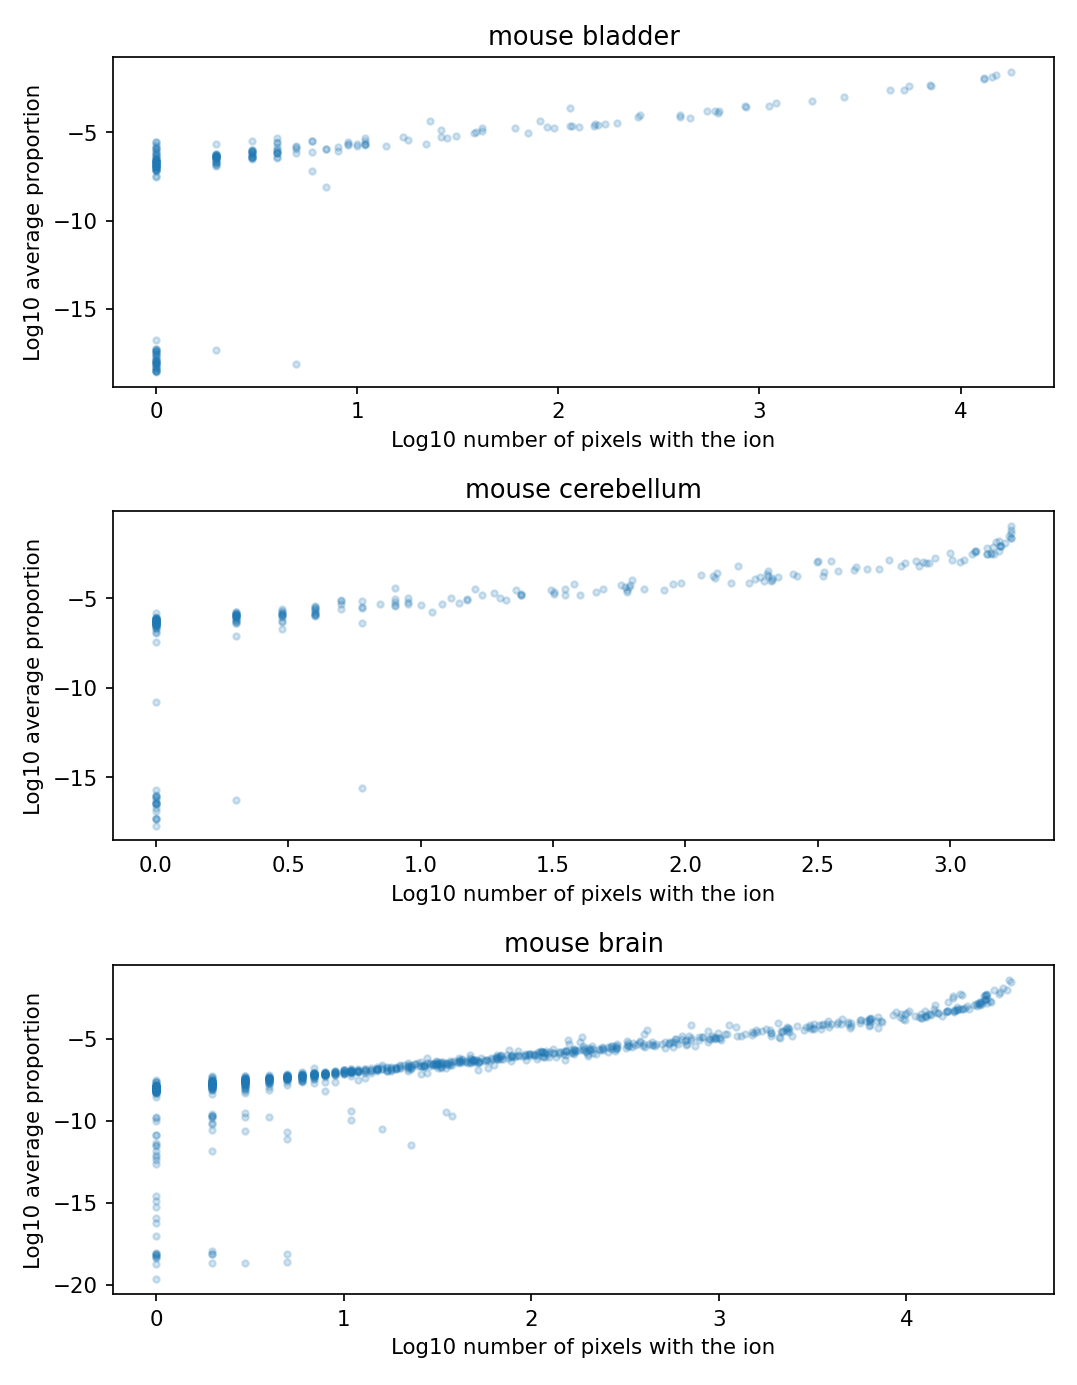

In [70]:
plt.figure(figsize=(7, 3*len(msi_names)))
for i,n in enumerate(msi_names):
    plt.subplot(len(msi_names), 1, 1+i) 
    nvect = number_of_nonzero_pixels[n]
    pvect = proportions_in_msi[n]
    is_present = pvect > 0  # implies nvect > 0
    present_nvect = nvect[is_present]
    present_pvect = pvect[is_present]
    plt.plot(np.log10(present_nvect), np.log10(present_pvect), '.', alpha=0.2)
    plt.title(n)
    plt.xlabel('Log10 number of pixels with the ion')
    plt.ylabel('Log10 average proportion')
plt.tight_layout() 

### Filtering and saving the annotations

Select the threshold of proportions for an ion to be considered present in the spectrum:  

In [57]:
# OPTIONAL USER INPUT
proportion_threshold_strategy2 = 1e-9  # the proportions needs to be above this threshold
# pixel_presence_threshold = 400  # optional

In [58]:
is_annotated_strategy2 = {}
for n in msi_names:
    to_keep_prop = proportions_in_msi[n] > proportion_threshold_strategy2
    # to_keep_pix = number_of_nonzero_pixels[n] > pixel_presence_threshold
    to_keep = to_keep_prop# *to_keep_pix
    is_annotated_strategy2[n] = to_keep
    print('Retained %i spectra for %s' % (sum(to_keep), n))

Retained 180 spectra for mouse bladder
Retained 209 spectra for mouse cerebellum
Retained 840 spectra for mouse brain


Save the annotation results:

In [59]:
for i,n in enumerate(msi_names):
    output_file = OUTPUT_FOLDER / n + ' thorough annotation results.tsv'
    with open(output_file, 'w') as h:
        props = proportions_in_msi[n]
        det = is_annotated_strategy2[n]
        pix = number_of_nonzero_pixels[n]
        # Write the header
        h.write('\t'.join(['Formula', 'Mass', 'Initial estimation', 'Number of pixels', 'Assigned']) + '\n')
        
        # Write the annotated formulas with their initially estimated proportions
        for l_id, s, p, px, d in zip(range(len(reference_spectra)), reference_spectra, props, pix, det):
            mz=s.confs[0][0]
            h.write('\t'.join([s.formula, str(mz), str(p), str(px), str(d)]) + '\n')